# BANK LOAN DEFAULT PREDICTION BASED ON A KAGGLE DATASET
PART ONE: READ, CLEANSE AND MERGE DATA; FEATURE ENGINEERING AND PRILIMINARY SELECTION

https://www.kaggle.com/zhunqiang/bank-data-loan-default

# 0. IMPORT PACKAGES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mlxtend.plotting import plot_decision_regions,category_scatter
import graphviz
from itertools import cycle, islice

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,cross_val_score,cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,OneHotEncoder,LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,precision_score, recall_score, accuracy_score,mean_squared_error,r2_score,accuracy_score,f1_score,roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipe

pd.set_option('display.max_columns', None)

# 1. READ,  FIRST GLANCE,  and INITIAL CLEANSE of DATA

## 1.A. CARD FILE

#### OBSERVATION: type - categorical; issued - object; 
#### TO-DO: issued - drop time, convert to int then datetime

In [3]:
card = pd.read_csv(
    "C:/Users/jinni/OneDrive/Documents/DataScience_Bootcamp/Julia_week5.5_Midterm/bank_loan/card.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
card

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00
...,...,...,...,...
887,125,694,gold,981226 00:00:00
888,674,4360,classic,981228 00:00:00
889,322,2063,classic,981228 00:00:00
890,685,4467,classic,981229 00:00:00


In [29]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  892 non-null    int64 
 1   disp_id  892 non-null    int64 
 2   type     892 non-null    object
 3   issued   892 non-null    object
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


In [30]:
card.type.value_counts()

classic    659
junior     145
gold        88
Name: type, dtype: int64

In [4]:
card.issued = card.issued.str.strip("00:00:00").astype(int)

card.issued = card.issued.apply(lambda x: pd.to_datetime(x, format="%y%m%d"))

card

,card_id,disp_id,type,issued
0,1005,9285,classic,1993-11-07
1,104,588,classic,1994-01-19
2,747,4915,classic,1994-02-05
3,70,439,classic,1994-02-08
4,577,3687,classic,1994-02-15
...,...,...,...,...
887,125,694,gold,1998-12-26
888,674,4360,classic,1998-12-28
889,322,2063,classic,1998-12-28
890,685,4467,classic,1998-12-29


In [32]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   card_id  892 non-null    int64         
 1   disp_id  892 non-null    int64         
 2   type     892 non-null    object        
 3   issued   892 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 28.0+ KB


## 1.B. ACCOUNT FILE

#### OBSERVATION: frequency - categorical/encoded; date - int64; 
#### TO-DO: frequency - decypher; date - convert to datetime

In [5]:
account = pd.read_csv(
    "C:/Users/jinni/OneDrive/Documents/DataScience_Bootcamp/Julia_week5.5_Midterm/bank_loan/account.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
account

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102
...,...,...,...,...
4495,124,55,POPLATEK MESICNE,971228
4496,3958,59,POPLATEK MESICNE,971228
4497,777,30,POPLATEK MESICNE,971228
4498,1573,63,POPLATEK MESICNE,971229


In [23]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 140.8+ KB


In [24]:
account.frequency.value_counts()

POPLATEK MESICNE      4167
POPLATEK TYDNE         240
POPLATEK PO OBRATU      93
Name: frequency, dtype: int64

In [6]:
account.frequency = account.frequency.map({'POPLATEK MESICNE':'monthly', 'POPLATEK TYDNE': 'weekly', 'POPLATEK PO OBRATU': 'per transaction'})
account.date = account.date.apply(lambda x: pd.to_datetime(x, format="%y%m%d"))
account.rename(columns={'date':'account_open_date'}, inplace=True)
account

,account_id,district_id,frequency,account_open_date
0,576,55,monthly,1993-01-01
1,3818,74,monthly,1993-01-01
2,704,55,monthly,1993-01-01
3,2378,16,monthly,1993-01-01
4,2632,24,monthly,1993-01-02
...,...,...,...,...
4495,124,55,monthly,1997-12-28
4496,3958,59,monthly,1997-12-28
4497,777,30,monthly,1997-12-28
4498,1573,63,monthly,1997-12-29


## 1.C. CLIENT FILE

#### OBSERVATION: birth_number - int64: yymmdd for men, yymm+50dd for women; 2-digit year is converted to 2000+ if bigger than 68
#### TO-DO: birth_number -  convert to datetime, extract gender and age

In [7]:
client = pd.read_csv(
    "C:/Users/jinni/OneDrive/Documents/DataScience_Bootcamp/Julia_week5.5_Midterm/bank_loan/client.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
client

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5
...,...,...,...
5364,13955,456030,1
5365,13956,430406,1
5366,13968,680413,61
5367,13971,626019,67


In [41]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


In [8]:
client['gender'] = client.birth_number.apply(lambda x: 'female' if (x-5000)//10000 == x//10000 else 'male')
client.birth_number = client.birth_number.apply(lambda x: x-5000 if (x-5000)//10000 == x//10000 else x)
client['age'] = client.birth_number.apply(lambda x: 99-x//10000)
client

,client_id,birth_number,district_id,gender,age
0,1,701213,18,female,29
1,2,450204,1,male,54
2,3,401009,1,female,59
3,4,561201,5,male,43
4,5,600703,5,female,39
...,...,...,...,...,...
5364,13955,451030,1,female,54
5365,13956,430406,1,male,56
5366,13968,680413,61,male,31
5367,13971,621019,67,female,37


## 1.D. DISP FILE

#### OBSERVATION: type - categorical, only owner is eligible for loans

#### TO-DO: type -  filter out anything that's not 'owner'

In [9]:
disp = pd.read_csv(
    "C:/Users/jinni/OneDrive/Documents/DataScience_Bootcamp/Julia_week5.5_Midterm/bank_loan/disp.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
disp

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT
...,...,...,...,...
5364,13647,13955,11349,OWNER
5365,13648,13956,11349,DISPONENT
5366,13660,13968,11359,OWNER
5367,13663,13971,11362,OWNER


In [62]:
disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


In [10]:
disp = disp[disp.type == 'OWNER']
disp.drop('type', axis=1, inplace=True)
disp

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,disp_id,client_id,account_id
0,1,1,1
1,2,2,2
3,4,4,3
5,6,6,4
6,7,7,5
...,...,...,...
5363,13623,13931,11333
5364,13647,13955,11349
5366,13660,13968,11359
5367,13663,13971,11362


## 1.E. DISTRICT FILE

#### OBSERVATION: A2, A3 - categorical, name of the district and the region

#### TO-DO: A2, A3 - drop

In [11]:
district = pd.read_csv(
    "C:/Users/jinni/OneDrive/Documents/DataScience_Bootcamp/Julia_week5.5_Midterm/bank_loan/district.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
district

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
74,75,Prerov,north Moravia,138032,67,30,4,2,5,64.6,8819,5.38,5.66,99,4063,4505
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107,3736,2807


In [12]:
district.drop(['A2','A3'], axis=1, inplace=True)
district.rename(columns={'A1':'district_id'}, inplace=True)
district

,district_id,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433
73,74,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
74,75,138032,67,30,4,2,5,64.6,8819,5.38,5.66,99,4063,4505
75,76,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107,3736,2807


## 1.F. LOAN FILE

#### OBSERVATION: date - int64; status - categorical/encoded

#### TO-DO: date - convert to datetime; status - decipher

In [13]:
loan = pd.read_csv(
    "C:/Users/jinni/OneDrive/Documents/DataScience_Bootcamp/Julia_week5.5_Midterm/bank_loan/loan.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
loan

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A
...,...,...,...,...,...,...,...
677,4989,105,981205,352704,48,7348.0,C
678,5221,1284,981205,52512,12,4376.0,C
679,6402,6922,981206,139488,24,5812.0,C
680,5346,1928,981206,55632,24,2318.0,C


In [69]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    int64  
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 37.4+ KB


In [78]:
loan.status.value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [14]:
loan.date = loan.date.apply(lambda x: pd.to_datetime(x, format="%y%m%d"))
loan.status = loan.status.map({'A':'finished, OK','B':'finished, not paid', 'C':'running, OK', 'D':'running, in debt'})
loan.rename(columns={'date':'loan_open_date'}, inplace=True)
loan

,loan_id,account_id,loan_open_date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,"finished, not paid"
1,5316,1801,1993-07-11,165960,36,4610.0,"finished, OK"
2,6863,9188,1993-07-28,127080,60,2118.0,"finished, OK"
3,5325,1843,1993-08-03,105804,36,2939.0,"finished, OK"
4,7240,11013,1993-09-06,274740,60,4579.0,"finished, OK"
...,...,...,...,...,...,...,...
677,4989,105,1998-12-05,352704,48,7348.0,"running, OK"
678,5221,1284,1998-12-05,52512,12,4376.0,"running, OK"
679,6402,6922,1998-12-06,139488,24,5812.0,"running, OK"
680,5346,1928,1998-12-06,55632,24,2318.0,"running, OK"


## 1.G. ORDER FILE

#### OBSERVATION: order_id, bank_to, account_to - no need for this; account_id + k_symbol - repeated; k_symbol - categorical/encoded/contains null values

#### TO-DO: order_id, bank_to, account_to - drop; account_id + k_symbol - group by to have avg and num; k_symbol - decipher/take care of null values

In [15]:
order = pd.read_csv(
    "C:/Users/jinni/OneDrive/Documents/DataScience_Bootcamp/Julia_week5.5_Midterm/bank_loan/order.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
order

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,
...,...,...,...,...,...,...
6466,46334,11362,YZ,70641225,4780.0,SIPO
6467,46335,11362,MN,78507822,56.0,
6468,46336,11362,ST,40799850,330.0,POJISTNE
6469,46337,11362,KL,20009470,129.0,


In [76]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    6471 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 303.5+ KB


In [80]:
order.k_symbol.value_counts()

SIPO        3502
            1379
UVER         717
POJISTNE     532
LEASING      341
Name: k_symbol, dtype: int64

In [16]:
order.k_symbol = order.k_symbol.map({'SIPO':'household payment', 'POJISTNE':'insurance payment', 'LEASING':'leasing', 'UVER':'loan payment', ' ': 'other'})
order.rename(columns={'k_symbol':'payment_type'}, inplace=True)
order.drop(['order_id','bank_to','account_to'], axis=1, inplace=True)
order

,account_id,amount,payment_type
0,1,2452.0,household payment
1,2,3372.7,loan payment
2,2,7266.0,household payment
3,3,1135.0,household payment
4,3,327.0,other
...,...,...,...
6466,11362,4780.0,household payment
6467,11362,56.0,other
6468,11362,330.0,insurance payment
6469,11362,129.0,other


In [17]:
order1 = order.copy()
order2 = order1.groupby(['account_id','payment_type']).mean().unstack()
order2 = order2.fillna(0)
order2.reset_index(level="account_id", col_level=1, inplace=True)
order2.columns = order2.columns.droplevel()
order2.rename_axis("", axis="columns", inplace=True)
order2.rename(index=None, columns={'household payment':'avg_house_order', 'loan payment':'avg_loan_order', 'other':'avg_other_order', 'insurance payment': 'avg_ins_order', 'leasing':'avg_lease_order' }, inplace=True)
order2

,account_id,avg_house_order,avg_ins_order,avg_lease_order,avg_loan_order,avg_other_order
0,1,2452.0,0.0,0.0,0.0,0.0
1,2,7266.0,0.0,0.0,3372.7,0.0
2,3,1135.0,3539.0,0.0,0.0,327.0
3,4,1681.5,0.0,0.0,0.0,0.0
4,5,2668.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3753,11328,0.0,0.0,0.0,4674.0,0.0
3754,11333,0.0,0.0,3286.7,0.0,0.0
3755,11349,10886.0,0.0,0.0,6998.0,0.0
3756,11359,4518.0,0.0,0.0,4502.3,254.0


In [18]:
order3 = order.copy()
order4 = order3.groupby(['account_id','payment_type']).count().unstack()
order4 = order4.fillna(0)
order4.reset_index(level="account_id", col_level=1, inplace=True)
order4.columns = order4.columns.droplevel()
order4.rename_axis("", axis="columns", inplace=True)
order4.rename(columns={'household payment':'num_house_order', 'loan payment':'num_loan_order', 'other':'num_other_order', 'insurance payment': 'num_ins_order', 'leasing':'num_lease_order' }, inplace=True)
order4

,account_id,num_house_order,num_ins_order,num_lease_order,num_loan_order,num_other_order
0,1,1.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,1.0,0.0
2,3,1.0,1.0,0.0,0.0,1.0
3,4,2.0,0.0,0.0,0.0,0.0
4,5,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3753,11328,0.0,0.0,0.0,1.0,0.0
3754,11333,0.0,0.0,1.0,0.0,0.0
3755,11349,1.0,0.0,0.0,1.0,0.0
3756,11359,1.0,0.0,0.0,1.0,1.0


In [19]:
order_combined = pd.merge(
    order2,
    order4,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
#    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
order_combined

,account_id,avg_house_order,avg_ins_order,avg_lease_order,avg_loan_order,avg_other_order,num_house_order,num_ins_order,num_lease_order,num_loan_order,num_other_order
0,1,2452.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,7266.0,0.0,0.0,3372.7,0.0,1.0,0.0,0.0,1.0,0.0
2,3,1135.0,3539.0,0.0,0.0,327.0,1.0,1.0,0.0,0.0,1.0
3,4,1681.5,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,5,2668.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3753,11328,0.0,0.0,0.0,4674.0,0.0,0.0,0.0,0.0,1.0,0.0
3754,11333,0.0,0.0,3286.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3755,11349,10886.0,0.0,0.0,6998.0,0.0,1.0,0.0,0.0,1.0,0.0
3756,11359,4518.0,0.0,0.0,4502.3,254.0,1.0,0.0,0.0,1.0,1.0


## 1.H. TRANS FILE

#### OBSERVATION: date - int64, type - categorical/encoded; operation - categorical/encoded/contains null values; k_symbol - categorical/encoded/contains null values; bank, account - no use

#### TO-DO: date - convert to datetime, type - decypher; operation - decipher/take care of null values; k_symbol - decipher/take care of null values; bank, account - drop

In [20]:
trans = pd.read_csv(
    "C:/Users/jinni/OneDrive/Documents/DataScience_Bootcamp/Julia_week5.5_Midterm/bank_loan/trans.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
trans

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1056315,3626622,2906,981231,PRIJEM,NaN,62.3,13729.4,UROK,NaN,NaN
1056316,3627616,2935,981231,PRIJEM,NaN,81.3,19544.9,UROK,NaN,NaN
1056317,3625403,2869,981231,PRIJEM,NaN,60.2,14638.2,UROK,NaN,NaN
1056318,3626683,2907,981231,PRIJEM,NaN,107.5,23453.0,UROK,NaN,NaN


In [152]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  int64  
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 80.6+ MB


In [154]:
trans.type.value_counts()

VYDAJ     634571
PRIJEM    405083
VYBER      16666
Name: type, dtype: int64

In [230]:
trans.operation.value_counts()

cash_withdrawal      434918
bank_remittance      208283
other                183114
cash_credit          156743
bank_collection       65226
credit_withdrawal      8036
Name: operation, dtype: int64

In [225]:
trans.k_symbol.value_counts()

UROK           183114
SLUZBY         155832
SIPO           118065
                53433
DUCHOD          30338
POJISTNE        18500
UVER            13580
SANKC. UROK      1577
Name: k_symbol, dtype: int64

In [21]:
trans.date = trans.date.apply(lambda x: pd.to_datetime(x, format="%y%m%d"))
trans.drop(['bank','account'], axis=1, inplace=True)
trans.fillna(' ', inplace=True)
trans.type = trans.type.map({'VYDAJ':'withdrawal', 'PRIJEM':'credit', 'VYBER':'withdrawal'})
trans.operation = trans.operation.map({'VYBER':'cash_withdrawal', 'PREVOD NA UCET':'bank_remittance', 'VKLAD':'cash_credit', 'PREVOD Z UCTU':'bank_collection', 'VYBER KARTOU': 'credit_withdrawal',' ':'other'})
trans.k_symbol = trans.k_symbol.map({'SIPO':'household_payment', 'SLUZBY':'payment for statement', 'POJISTNE':'insurance_payment', 'UROK':'interest_credit', 'DUCHOD':'pension', 'UVER':'loan_payment', 'SANKC. UROK':'interest_sanction', ' ':'other'})
trans

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,695247,2378,1993-01-01,credit,cash_credit,700.0,700.0,other
1,171812,576,1993-01-01,credit,cash_credit,900.0,900.0,other
2,207264,704,1993-01-01,credit,cash_credit,1000.0,1000.0,other
3,1117247,3818,1993-01-01,credit,cash_credit,600.0,600.0,other
4,579373,1972,1993-01-02,credit,cash_credit,400.0,400.0,other
...,...,...,...,...,...,...,...,...
1056315,3626622,2906,1998-12-31,credit,other,62.3,13729.4,interest_credit
1056316,3627616,2935,1998-12-31,credit,other,81.3,19544.9,interest_credit
1056317,3625403,2869,1998-12-31,credit,other,60.2,14638.2,interest_credit
1056318,3626683,2907,1998-12-31,credit,other,107.5,23453.0,interest_credit


In [22]:
trans.loc[trans.k_symbol.isnull()]

,trans_id,account_id,date,type,operation,amount,balance,k_symbol


In [1]:
get_date_loan_trans = pd.merge(
    loan,
    trans,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_trans"),
    copy=True,
    indicator=False,
    validate=None,
)
get_date_loan_trans

NameError: name 'pd' is not defined

In [273]:
trans_before_loan = get_date_loan_trans[get_date_loan_trans.date <= get_date_loan_trans.loan_open_date]
trans_before_loan['amount_trans'] = trans_before_loan.amount_trans.mul(np.where(trans_before_loan.type == 'credit', 1, -1), axis=0)
trans_before_loan

<ipython-input-273-9e71d648f3cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_before_loan['amount_trans'] = trans_before_loan.amount_trans.mul(np.where(trans_before_loan.type == 'credit', 1, -1), axis=0)


,loan_id,account_id,loan_open_date,amount_loan,duration,payments,status,trans_id,date,type,operation,amount_trans,balance,k_symbol
0,5314,1787,1993-07-05,96396,12,8033.0,"finished, not paid",523621,1993-03-22,credit,cash_credit,1100.0,1100.0,other
1,5314,1787,1993-07-05,96396,12,8033.0,"finished, not paid",524054,1993-04-21,credit,cash_credit,9900.0,11000.0,other
2,5314,1787,1993-07-05,96396,12,8033.0,"finished, not paid",524055,1993-05-21,credit,cash_credit,5800.0,16800.0,other
3,5314,1787,1993-07-05,96396,12,8033.0,"finished, not paid",524056,1993-06-20,credit,cash_credit,3300.0,20100.0,other
403,5316,1801,1993-07-11,165960,36,4610.0,"finished, OK",527445,1993-02-13,credit,cash_credit,700.0,700.0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191546,6748,8645,1998-12-08,240900,60,4015.0,"running, OK",2616397,1998-11-15,withdrawal,cash_withdrawal,-1800.0,28535.7,other
191547,6748,8645,1998-12-08,240900,60,4015.0,"running, OK",3502674,1998-11-30,credit,other,105.8,28747.4,interest_credit
191548,6748,8645,1998-12-08,240900,60,4015.0,"running, OK",2616380,1998-11-30,withdrawal,cash_withdrawal,-14.6,28732.8,payment for statement
191549,6748,8645,1998-12-08,240900,60,4015.0,"running, OK",3476398,1998-11-30,credit,other,105.8,28641.6,interest_credit


In [126]:
trans_before_loan.columns

Index(['loan_id', 'account_id', 'loan_open_date', 'amount_loan', 'duration',
       'payments', 'status', 'trans_id', 'date', 'type', 'operation',
       'amount_trans', 'balance', 'k_symbol'],
      dtype='object')

In [278]:
trans_before_loan_min = trans_before_loan.copy() 
trans_before_loan_min.drop(['loan_open_date','loan_id', 'amount_loan', 'duration',
       'payments', 'status', 'trans_id', 'date', 'type', 'operation',
       'amount_trans', 'k_symbol'], axis=1, inplace=True)
min_balance = trans_before_loan_min.groupby(['account_id']).min()
min_balance.reset_index(level=['account_id'], col_level=1, inplace=True)
min_balance.rename(columns={'balance':'min_balance'}, inplace=True)
min_balance

,account_id,min_balance
0,2,1100.0
1,19,715.0
2,25,900.0
3,37,-1011.2
4,38,13841.0
...,...,...
677,11327,300.0
678,11328,1000.0
679,11349,200.0
680,11359,1000.0


In [277]:
trans_before_loan_mean = trans_before_loan.copy() 
trans_before_loan_mean.drop(['loan_open_date', 'loan_id','amount_loan', 'duration',
       'payments', 'status', 'trans_id', 'date', 'type', 'operation',
       'amount_trans', 'k_symbol'], axis=1, inplace=True)
mean_balance = trans_before_loan_mean.groupby(['account_id']).mean()
mean_balance.reset_index(level=['account_id'], col_level=1, inplace=True)
mean_balance.rename(columns={'balance':'mean_balance'}, inplace=True)
mean_balance

,account_id,mean_balance
0,2,32372.150909
1,19,25197.092500
2,25,62800.153333
3,37,39953.970690
4,38,31383.449091
...,...,...
677,11327,55438.851852
678,11328,38503.066355
679,11349,59352.833333
680,11359,36376.701351


In [279]:
trans_before_loan1 = trans_before_loan.copy()
trans_before_loan1.drop([ 'loan_open_date','loan_id', 'amount_loan', 'duration',
       'payments', 'status', 'trans_id', 'date','balance'], axis=1, inplace=True)
trans_before_loan2 = trans_before_loan1.groupby(['account_id','k_symbol']).mean().unstack()
trans_before_loan2.reset_index(level="account_id", col_level=1, inplace=True)
trans_before_loan2.columns = trans_before_loan2.columns.droplevel()
trans_before_loan2.rename_axis("", axis="columns", inplace=True)
# # trans_before_loan2.rename(index=None, columns={'household payment':'avg_house_order', 'loan payment':'avg_loan_order', 'other':'avg_other_order', 'insurance payment': 'avg_ins_order', 'leasing':'avg_lease_order' }, inplace=True)
trans_before_loan2 = trans_before_loan2.fillna(0)
trans_before_loan2

,account_id,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement
0,2,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6
1,19,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6
2,25,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6
3,37,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6
4,38,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0
...,...,...,...,...,...,...,...,...
677,11327,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6
678,11328,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6
679,11349,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0
680,11359,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6


In [280]:
trans_before_loan3 = trans_before_loan.copy()
trans_before_loan3.drop(['loan_id', 'trans_id', 'date',  'type', 'operation',
       'amount_trans', 'balance', 'k_symbol'], axis=1, inplace=True)
trans_before_loan4 = trans_before_loan3.groupby(['account_id','status','loan_open_date']).mean()
trans_before_loan4.reset_index(level=['account_id','status','loan_open_date'], col_level=1, inplace=True)
trans_before_loan4

,account_id,status,loan_open_date,amount_loan,duration,payments
0,2,"finished, OK",1994-01-05,80952,24,3373.0
1,19,"finished, not paid",1996-04-29,30276,12,2523.0
2,25,"finished, OK",1997-12-08,30276,12,2523.0
3,37,"running, in debt",1998-10-14,318480,60,5308.0
4,38,"running, OK",1998-04-19,110736,48,2307.0
...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0
678,11328,"running, OK",1998-07-18,280440,60,4674.0
679,11349,"running, OK",1995-10-29,419880,60,6998.0
680,11359,"finished, OK",1996-08-06,54024,12,4502.0


In [283]:
trans_before_loan_mean_trans = trans_before_loan.copy() 
trans_before_loan_mean_trans.drop(['loan_open_date', 'amount_loan', 'duration',
       'payments', 'status', 'trans_id', 'date', 'type', 'operation',
       'balance', 'k_symbol','loan_id'], axis=1, inplace=True)
mean_amount = trans_before_loan_mean_trans.groupby(['account_id']).mean()
mean_amount.reset_index(level="account_id", col_level=1, inplace=True)
mean_amount.rename(index=None, columns={'amount_trans':'mean_trans_amount'}, inplace=True)
mean_amount

,account_id,mean_trans_amount
0,2,374.085455
1,19,198.180000
2,25,190.653939
3,37,141.102586
4,38,680.303636
...,...,...
677,11327,1150.357407
678,11328,244.890654
679,11349,1372.472222
680,11359,143.004054


In [284]:
trans_before_loan_42 = pd.merge(
    trans_before_loan4,
    trans_before_loan2,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
#    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_before_loan_42

,account_id,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement
0,2,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6
1,19,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6
2,25,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6
3,37,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6
4,38,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6
678,11328,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6
679,11349,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0
680,11359,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6


In [288]:
trans_min_mean = pd.merge(
    min_balance,
    mean_balance,
#    mean_amount,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
#    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_min_mean = pd.merge(
    trans_min_mean,
    mean_amount,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
#    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_min_mean

,account_id,min_balance,mean_balance,mean_trans_amount
0,2,1100.0,32372.150909,374.085455
1,19,715.0,25197.092500,198.180000
2,25,900.0,62800.153333,190.653939
3,37,-1011.2,39953.970690,141.102586
4,38,13841.0,31383.449091,680.303636
...,...,...,...,...
677,11327,300.0,55438.851852,1150.357407
678,11328,1000.0,38503.066355,244.890654
679,11349,200.0,59352.833333,1372.472222
680,11359,1000.0,36376.701351,143.004054


In [289]:
trans_before_loan_combined = pd.merge( 
    trans_before_loan_42,
    trans_min_mean,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
#    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_before_loan_combined

,account_id,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount
0,2,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455
1,19,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000
2,25,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939
3,37,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586
4,38,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407
678,11328,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654
679,11349,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222
680,11359,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054


# 2. MERGE TABLES and SELECT RELEVANT DATA FOR THE TASK

## 2.A. MERGE LOAN AND TRANS

#### OBSERVATION: 

#### TO-DO: FILTER OUT TRANSACTIONS AFTER THE LOAN WAS GRANTED

In [290]:
account_trans_loan = pd.merge(
    trans_before_loan_combined,   
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_trans", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
account_trans_loan.drop(['account_open_date'], axis=1, inplace=True)
account_trans_loan

,account_id,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,district_id,frequency
0,2,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,1,monthly
1,19,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,21,monthly
2,25,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,68,monthly
3,37,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,20,monthly
4,38,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,19,weekly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,7,monthly
678,11328,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,54,monthly
679,11349,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,1,weekly
680,11359,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,61,monthly


In [291]:
account_disp_trans_loan = pd.merge(
    account_trans_loan,
    disp,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_trans", "_disp"),
    copy=True,
    indicator=False,
    validate=None,
)
account_disp_trans_loan

,account_id,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,district_id,frequency,disp_id,client_id
0,2,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,1,monthly,2,2
1,19,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,21,monthly,25,25
2,25,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,68,monthly,31,31
3,37,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,20,monthly,45,45
4,38,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,19,weekly,46,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,7,monthly,13615,13923
678,11328,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,54,monthly,13616,13924
679,11349,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,1,weekly,13647,13955
680,11359,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,61,monthly,13660,13968


In [292]:
account_disp_client_trans_loan = pd.merge(
    account_disp_trans_loan,
    client,
    how="left",
    on="client_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_trans", "_client"),
    copy=True,
    indicator=False,
    validate=None,
)
account_disp_client_trans_loan.drop(['district_id_client','birth_number'], axis=1, inplace=True)
account_disp_client_trans_loan

,account_id,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,district_id_trans,frequency,disp_id,client_id,gender,age
0,2,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,1,monthly,2,2,male,54
1,19,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,21,monthly,25,25,female,60
2,25,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,68,monthly,31,31,male,37
3,37,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,20,monthly,45,45,male,47
4,38,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,19,weekly,46,46,female,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,7,monthly,13615,13923,female,20
678,11328,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,54,monthly,13616,13924,female,47
679,11349,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,1,weekly,13647,13955,female,54
680,11359,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,61,monthly,13660,13968,male,31


In [293]:
account_disp_client_card_trans_loan = pd.merge(
    account_disp_client_trans_loan,
    card,
    how="left",
    on="disp_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_trans", "_card"),
    copy=True,
    indicator=False,
    validate=None,
)
account_disp_client_card_trans_loan

,account_id,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,district_id_trans,frequency,disp_id,client_id,gender,age,card_id,type,issued
0,2,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,1,monthly,2,2,male,54,NaN,NaN,NaT
1,19,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,21,monthly,25,25,female,60,NaN,NaN,NaT
2,25,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,68,monthly,31,31,male,37,NaN,NaN,NaT
3,37,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,20,monthly,45,45,male,47,NaN,NaN,NaT
4,38,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,19,weekly,46,46,female,59,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,7,monthly,13615,13923,female,20,NaN,NaN,NaT
678,11328,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,54,monthly,13616,13924,female,47,NaN,NaN,NaT
679,11349,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,1,weekly,13647,13955,female,54,NaN,NaN,NaT
680,11359,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,61,monthly,13660,13968,male,31,1247.0,classic,1995-06-13


In [294]:
account_disp_client_card_order_trans_loan = pd.merge(
    account_disp_client_card_trans_loan,
    order_combined,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_trans", "_order"),
    copy=True,
    indicator=False,
    validate=None,
)
account_disp_client_card_order_trans_loan.rename(columns={'district_id_trans':'district_id'}, inplace=True)
account_disp_client_card_order_trans_loan

,account_id,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,district_id,frequency,disp_id,client_id,gender,age,card_id,type,issued,avg_house_order,avg_ins_order,avg_lease_order,avg_loan_order,avg_other_order,num_house_order,num_ins_order,num_lease_order,num_loan_order,num_other_order
0,2,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,1,monthly,2,2,male,54,NaN,NaN,NaT,7266.0,0.0,0.0,3372.7,0.0,1.0,0.0,0.0,1.0,0.0
1,19,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,21,monthly,25,25,female,60,NaN,NaN,NaT,0.0,0.0,0.0,2523.2,0.0,0.0,0.0,0.0,1.0,0.0
2,25,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,68,monthly,31,31,male,37,NaN,NaN,NaT,6817.0,164.0,0.0,2523.2,1110.0,1.0,1.0,0.0,1.0,1.0
3,37,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,20,monthly,45,45,male,47,NaN,NaN,NaT,2317.0,97.0,0.0,5307.5,2584.0,1.0,1.0,0.0,1.0,1.0
4,38,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,19,weekly,46,46,female,59,NaN,NaN,NaT,6901.0,228.0,0.0,2306.8,231.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,7,monthly,13615,13923,female,20,NaN,NaN,NaT,3693.0,0.0,0.0,1632.0,0.0,1.0,0.0,0.0,1.0,0.0
678,11328,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,54,monthly,13616,13924,female,47,NaN,NaN,NaT,0.0,0.0,0.0,4674.0,0.0,0.0,0.0,0.0,1.0,0.0
679,11349,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,1,weekly,13647,13955,female,54,NaN,NaN,NaT,10886.0,0.0,0.0,6998.0,0.0,1.0,0.0,0.0,1.0,0.0
680,11359,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,61,monthly,13660,13968,male,31,1247.0,classic,1995-06-13,4518.0,0.0,0.0,4502.3,254.0,1.0,0.0,0.0,1.0,1.0


In [295]:
account_disp_district_client_card_order_trans_loan = pd.merge(
    account_disp_client_card_order_trans_loan,
    district,
    how="left",
    on="district_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_trans", "_district"),
    copy=True,
    indicator=False,
    validate=None,
)
account_disp_district_client_card_order_trans_loan

,account_id,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,district_id,frequency,disp_id,client_id,gender,age,card_id,type,issued,avg_house_order,avg_ins_order,avg_lease_order,avg_loan_order,avg_other_order,num_house_order,num_ins_order,num_lease_order,num_loan_order,num_other_order,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,2,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,1,monthly,2,2,male,54,NaN,NaN,NaT,7266.0,0.0,0.0,3372.7,0.0,1.0,0.0,0.0,1.0,0.0,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,19,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,21,monthly,25,25,female,60,NaN,NaN,NaT,0.0,0.0,0.0,2523.2,0.0,0.0,0.0,0.0,1.0,0.0,103347,87,16,7,1,7,67.0,9104,1.51,2.07,123,2299,2354
2,25,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,68,monthly,31,31,male,37,NaN,NaN,NaT,6817.0,164.0,0.0,2523.2,1110.0,1.0,1.0,0.0,1.0,1.0,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887
3,37,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,20,monthly,45,45,male,47,NaN,NaN,NaT,2317.0,97.0,0.0,5307.5,2584.0,1.0,1.0,0.0,1.0,1.0,70646,94,14,3,1,4,58.4,8547,2.65,3.64,120,1563,1542
4,38,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,19,weekly,46,46,female,59,NaN,NaN,NaT,6901.0,228.0,0.0,2306.8,231.0,1.0,1.0,0.0,1.0,1.0,51428,50,11,3,1,4,52.7,8402,3.13,3.98,120,999,1099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,7,monthly,13615,13923,female,20,NaN,NaN,NaT,3693.0,0.0,0.0,1632.0,0.0,1.0,0.0,0.0,1.0,0.0,94725,38,28,1,3,6,63.4,9920,2.26,2.87,130,4289,4846
678,11328,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,54,monthly,13616,13924,female,47,NaN,NaN,NaT,0.0,0.0,0.0,4674.0,0.0,0.0,0.0,0.0,1.0,0.0,387570,0,0,0,1,1,100.0,9897,1.60,1.96,140,18721,18696
679,11349,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,1,weekly,13647,13955,female,54,NaN,NaN,NaT,10886.0,0.0,0.0,6998.0,0.0,1.0,0.0,0.0,1.0,0.0,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
680,11359,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,61,monthly,13660,13968,male,31,1247.0,classic,1995-06-13,4518.0,0.0,0.0,4502.3,254.0,1.0,0.0,0.0,1.0,1.0,117897,139,28,5,1,6,53.8,8814,4.76,5.74,107,2112,2059


# 3. FEATURE ENGINEERING AND PRILIMINARY SELECTION

In [380]:
df = account_disp_district_client_card_order_trans_loan.copy()
df.drop(['account_id','district_id','disp_id','client_id','card_id'], axis=1, inplace=True)

In [299]:
df.describe()

,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,age,avg_house_order,avg_ins_order,avg_lease_order,avg_loan_order,avg_other_order,num_house_order,num_ins_order,num_lease_order,num_loan_order,num_other_order,A4,A5,A6,A7,A8,A9,A10,A11,A13,A14,A16
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.0,682.000000,682.000000,682.000000,682.000000,682.0,682.0,682.000000,6.820000e+02,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,151410.175953,36.492669,4190.664223,-3576.480376,-253.862170,167.463710,-0.319607,-128.607625,1925.339150,-18.822287,651.998974,43610.125065,890.626611,40.901760,3570.620235,267.629032,0.0,4190.660264,887.621701,0.646628,0.167155,0.0,1.0,0.404692,2.720522e+05,39.673021,21.557185,5.648094,1.712610,5.406158,68.212903,9502.986804,3.528431,121.218475,16390.818182
std,113372.406310,17.075219,2215.830344,3975.614334,1023.743639,55.370427,2.315366,807.476245,1532.321530,18.468028,1848.989323,13472.368040,1092.862434,12.688891,3874.265471,1059.675342,0.0,2215.840858,1932.712480,0.478368,0.373388,0.0,0.0,0.606263,3.583320e+05,33.673348,15.780258,4.588747,1.110404,2.868251,20.245469,1323.150982,2.146775,23.366091,31299.743394
min,4980.000000,12.000000,304.000000,-15925.000000,-9115.000000,0.000000,-35.540000,-9112.000000,-75.342105,-100.000000,-17030.400000,5350.000000,-33.310937,19.000000,0.000000,0.000000,0.0,304.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,4.282100e+04,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,0.430000,81.000000,888.000000
25%,66732.000000,24.000000,2477.000000,-6246.000000,0.000000,127.341995,0.000000,0.000000,922.903270,-14.600000,300.000000,32833.034787,294.329946,30.000000,0.000000,0.000000,0.0,2476.800000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,9.208400e+04,5.000000,10.000000,2.000000,1.000000,4.000000,52.000000,8544.000000,1.960000,106.000000,2305.000000
50%,116928.000000,36.000000,3934.000000,-2591.500000,0.000000,163.741667,0.000000,0.000000,1572.555269,-14.600000,600.000000,43207.931166,494.517838,41.000000,2685.000000,0.000000,0.0,3934.050000,0.000000,1.000000,0.000000,0.0,1.0,0.000000,1.246050e+05,35.000000,23.000000,5.000000,1.000000,6.000000,62.100000,8991.000000,3.490000,116.000000,3868.000000
75%,210654.000000,48.000000,5813.500000,0.000000,0.000000,204.365057,0.000000,0.000000,2440.791071,-14.600000,900.000000,53613.958260,965.442703,52.000000,6246.000000,0.000000,0.0,5813.050000,784.000000,1.000000,0.000000,0.0,1.0,1.000000,2.261220e+05,65.000000,33.000000,8.000000,2.000000,7.000000,87.700000,9897.000000,4.790000,132.000000,6872.000000
max,590820.000000,60.000000,9910.000000,0.000000,0.000000,334.923077,0.000000,0.000000,12521.125000,0.000000,20574.000000,79500.538095,9152.309091,64.000000,14882.000000,9115.000000,0.0,9910.000000,11766.000000,1.000000,1.000000,0.0,1.0,2.000000,1.204953e+06,151.000000,70.000000,20.000000,5.000000,11.000000,100.000000,12541.000000,9.400000,167.000000,99107.000000


In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   status                 682 non-null    object        
 1   loan_open_date         682 non-null    datetime64[ns]
 2   amount_loan            682 non-null    int64         
 3   duration               682 non-null    int64         
 4   payments               682 non-null    float64       
 5   household_payment      682 non-null    float64       
 6   insurance_payment      682 non-null    float64       
 7   interest_credit        682 non-null    float64       
 8   interest_sanction      682 non-null    float64       
 9   loan_payment           682 non-null    float64       
 10  other                  682 non-null    float64       
 11  payment for statement  682 non-null    float64       
 12  min_balance            682 non-null    float64       
 13  mean_

In [381]:
df['type'] = df.type.map({'classic':1, 'junior':1, 'gold':1}, na_action='ignore')
df['type'] = df.type.where(df.loan_open_date > df.issued, 0)
df.drop(['issued'], axis=1, inplace=True)
df

,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,frequency,gender,age,type,avg_house_order,avg_ins_order,avg_lease_order,avg_loan_order,avg_other_order,num_house_order,num_ins_order,num_lease_order,num_loan_order,num_other_order,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,"finished, OK",1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,monthly,male,54,0.0,7266.0,0.0,0.0,3372.7,0.0,1.0,0.0,0.0,1.0,0.0,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,"finished, not paid",1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,monthly,female,60,0.0,0.0,0.0,0.0,2523.2,0.0,0.0,0.0,0.0,1.0,0.0,103347,87,16,7,1,7,67.0,9104,1.51,2.07,123,2299,2354
2,"finished, OK",1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,monthly,male,37,0.0,6817.0,164.0,0.0,2523.2,1110.0,1.0,1.0,0.0,1.0,1.0,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887
3,"running, in debt",1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,monthly,male,47,0.0,2317.0,97.0,0.0,5307.5,2584.0,1.0,1.0,0.0,1.0,1.0,70646,94,14,3,1,4,58.4,8547,2.65,3.64,120,1563,1542
4,"running, OK",1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,weekly,female,59,0.0,6901.0,228.0,0.0,2306.8,231.0,1.0,1.0,0.0,1.0,1.0,51428,50,11,3,1,4,52.7,8402,3.13,3.98,120,999,1099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,"running, OK",1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,monthly,female,20,0.0,3693.0,0.0,0.0,1632.0,0.0,1.0,0.0,0.0,1.0,0.0,94725,38,28,1,3,6,63.4,9920,2.26,2.87,130,4289,4846
678,"running, OK",1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,monthly,female,47,0.0,0.0,0.0,0.0,4674.0,0.0,0.0,0.0,0.0,1.0,0.0,387570,0,0,0,1,1,100.0,9897,1.60,1.96,140,18721,18696
679,"running, OK",1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,weekly,female,54,0.0,10886.0,0.0,0.0,6998.0,0.0,1.0,0.0,0.0,1.0,0.0,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
680,"finished, OK",1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,monthly,male,31,1.0,4518.0,0.0,0.0,4502.3,254.0,1.0,0.0,0.0,1.0,1.0,117897,139,28,5,1,6,53.8,8814,4.76,5.74,107,2112,2059


In [382]:
df['age'] = df['age']-(1999-df['loan_open_date'].dt.year)
df.drop(['loan_open_date'], axis=1, inplace=True)
df['age'].value_counts().sort_index()

13     1
14     2
15     5
16     8
17     8
18    12
19    21
20    14
21     8
22    12
23    14
24    19
25    19
26    13
27    20
28    11
29    14
30    19
31    15
32    22
33    16
34    16
35    20
36     7
37    23
38    12
39    17
40    12
41    21
42     9
43    12
44    18
45    15
46    19
47    18
48    11
49    18
50    10
51    20
52     9
53    16
54    17
55    16
56    11
57    18
58    17
59     6
60    10
61     6
62     5
Name: age, dtype: int64

In [383]:
r = {range(13,18):1, range(18,30):2, range(30,40):3, range(40,50):4, range(50,63):5}
df['age_range'] = df.age.apply(lambda x: next((v for k, v in r.items() if x in k), 0))
df['age_range'].value_counts()

2    177
3    167
5    161
4    153
1     24
Name: age_range, dtype: int64

In [384]:
r = {range(1,100000):2, range(100000,1000000):1, range(1000000,4000000):0}
df['A4_range'] = df.A4.apply(lambda x: next((v for k, v in r.items() if x in k), 0))
df['A4_range'].value_counts()

1    388
2    210
0     84
Name: A4_range, dtype: int64

In [400]:
df['status'] = df.status.map({'running, OK':0, 'finished, OK':0, 'running, in debt':1, 'finished, not paid':1})
df['frequency'] = df.frequency.map({'monthly':2, 'weekly':1, 'per transaction':0})
df['gender'] = df.gender.map({'male':0, 'female':1})
df

,status,loan_open_date,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,frequency,gender,age,type,avg_house_order,avg_ins_order,avg_lease_order,avg_loan_order,avg_other_order,num_house_order,num_ins_order,num_lease_order,num_loan_order,num_other_order,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,age_range,A4_range
0,0,1994-01-05,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,2,0,49,0.0,7266.0,0.0,0.0,3372.7,0.0,1.0,0.0,0.0,1.0,0.0,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107,4,0
1,1,1996-04-29,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,2,1,57,0.0,0.0,0.0,0.0,2523.2,0.0,0.0,0.0,0.0,1.0,0.0,103347,87,16,7,1,7,67.0,9104,1.51,2.07,123,2299,2354,5,1
2,0,1997-12-08,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,2,0,35,0.0,6817.0,164.0,0.0,2523.2,1110.0,1.0,1.0,0.0,1.0,1.0,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887,3,1
3,1,1998-10-14,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,2,0,46,0.0,2317.0,97.0,0.0,5307.5,2584.0,1.0,1.0,0.0,1.0,1.0,70646,94,14,3,1,4,58.4,8547,2.65,3.64,120,1563,1542,4,2
4,0,1998-04-19,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,1,1,58,0.0,6901.0,228.0,0.0,2306.8,231.0,1.0,1.0,0.0,1.0,1.0,51428,50,11,3,1,4,52.7,8402,3.13,3.98,120,999,1099,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0,1998-09-27,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,2,1,19,0.0,3693.0,0.0,0.0,1632.0,0.0,1.0,0.0,0.0,1.0,0.0,94725,38,28,1,3,6,63.4,9920,2.26,2.87,130,4289,4846,2,2
678,0,1998-07-18,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,2,1,46,0.0,0.0,0.0,0.0,4674.0,0.0,0.0,0.0,0.0,1.0,0.0,387570,0,0,0,1,1,100.0,9897,1.60,1.96,140,18721,18696,4,1
679,0,1995-10-29,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,1,1,50,0.0,10886.0,0.0,0.0,6998.0,0.0,1.0,0.0,0.0,1.0,0.0,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107,5,0
680,0,1996-08-06,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,2,0,28,1.0,4518.0,0.0,0.0,4502.3,254.0,1.0,0.0,0.0,1.0,1.0,117897,139,28,5,1,6,53.8,8814,4.76,5.74,107,2112,2059,2,1


In [389]:
df.amount_loan.min()

4980

In [387]:
df.amount_loan.quantile(0.25)

66732.0

In [391]:
df.amount_loan.median()

116928.0

In [392]:
df.amount_loan.mean()

151410.1759530792

In [388]:
df.amount_loan.quantile(0.75)

210654.0

In [390]:
df.amount_loan.max()

590820

In [397]:
df.amount_loan.apply(lambda x: x//1000).value_counts().sort_index()

4      1
5      1
7      1
8      1
10     1
11     2
12     2
14     2
15     2
16     1
17     3
18     3
19     2
20     4
21     4
22     5
23     6
24     4
25     1
26     1
27     2
28     1
29     2
30     6
31     6
32     1
33     3
34     1
35     2
36     4
37     3
38     3
39     4
40     1
41     5
42     4
43     2
44     8
45     6
46     2
47     2
48     5
49     6
50     3
51     3
52     4
53     3
54     2
55     2
56     1
57     3
58     1
59     4
60     2
61     4
63     5
64     3
65     1
66     5
67     5
68     7
69     3
70     1
71     5
72     3
73     3
74     7
75     1
76     8
77     4
78     4
79     5
80     3
81     1
82     2
83     4
84     4
85     3
86     5
87     7
88     5
89     5
90     2
91     6
92     2
93     5
94     2
95     2
96     4
97     5
98     4
99     6
100    6
101    1
102    2
103    1
104    4
105    1
106    2
107    2
108    2
109    1
110    4
111    1
112    1
113    3
115    2
116    3
117    2
119    1
120    1
1

In [403]:
df

,status,amount_loan,duration,payments,household_payment,insurance_payment,interest_credit,interest_sanction,loan_payment,other,payment for statement,min_balance,mean_balance,mean_trans_amount,frequency,gender,age,type,avg_house_order,avg_ins_order,avg_lease_order,avg_loan_order,avg_other_order,num_house_order,num_ins_order,num_lease_order,num_loan_order,num_other_order,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,age_range,A4_range
0,0,80952,24,3373.0,-7266.0,0.0,128.930000,0.0,0.0,1908.151515,-14.6,1100.0,32372.150909,374.085455,2,0,49,0.0,7266.0,0.0,0.0,3372.7,0.0,1.0,0.0,0.0,1.0,0.0,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107,4,0
1,1,30276,12,2523.0,-15925.0,0.0,118.091667,0.0,0.0,3513.425000,-14.6,715.0,25197.092500,198.180000,2,1,57,0.0,0.0,0.0,0.0,2523.2,0.0,0.0,0.0,0.0,1.0,0.0,103347,87,16,7,1,7,67.0,9104,1.51,2.07,123,2299,2354,5,1
2,0,30276,12,2523.0,-6817.0,-164.0,272.286667,0.0,0.0,1172.672897,-14.6,900.0,62800.153333,190.653939,2,0,35,0.0,6817.0,164.0,0.0,2523.2,1110.0,1.0,1.0,0.0,1.0,1.0,228848,15,40,18,2,6,57.2,9893,4.09,4.72,96,5623,5887,3,1
3,1,318480,60,5308.0,-2317.0,-97.0,164.492857,-0.4,0.0,654.454545,-14.6,-1011.2,39953.970690,141.102586,2,0,46,0.0,2317.0,97.0,0.0,5307.5,2584.0,1.0,1.0,0.0,1.0,1.0,70646,94,14,3,1,4,58.4,8547,2.65,3.64,120,1563,1542,4,2
4,0,110736,48,2307.0,-6901.0,-228.0,139.212500,0.0,0.0,1855.400000,-30.0,13841.0,31383.449091,680.303636,1,1,58,0.0,6901.0,228.0,0.0,2306.8,231.0,1.0,1.0,0.0,1.0,1.0,51428,50,11,3,1,4,52.7,8402,3.13,3.98,120,999,1099,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0,39168,24,1632.0,-3693.0,0.0,216.890000,0.0,0.0,2568.625000,-14.6,300.0,55438.851852,1150.357407,2,1,19,0.0,3693.0,0.0,0.0,1632.0,0.0,1.0,0.0,0.0,1.0,0.0,94725,38,28,1,3,6,63.4,9920,2.26,2.87,130,4289,4846,2,2
678,0,280440,60,4674.0,0.0,0.0,179.489474,0.0,0.0,315.232877,-14.6,1000.0,38503.066355,244.890654,2,1,46,0.0,0.0,0.0,0.0,4674.0,0.0,0.0,0.0,0.0,1.0,0.0,387570,0,0,0,1,1,100.0,9897,1.60,1.96,140,18721,18696,4,1
679,0,419880,60,6998.0,-10886.0,0.0,189.125000,0.0,0.0,2679.538462,0.0,200.0,59352.833333,1372.472222,1,1,50,0.0,10886.0,0.0,0.0,6998.0,0.0,1.0,0.0,0.0,1.0,0.0,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107,5,0
680,0,54024,12,4502.0,-4518.0,0.0,163.472727,0.0,0.0,1101.722222,-14.6,1000.0,36376.701351,143.004054,2,0,28,1.0,4518.0,0.0,0.0,4502.3,254.0,1.0,0.0,0.0,1.0,1.0,117897,139,28,5,1,6,53.8,8814,4.76,5.74,107,2112,2059,2,1


# 4. EXPLORATORY DATA ANALYSIS

<AxesSubplot:>

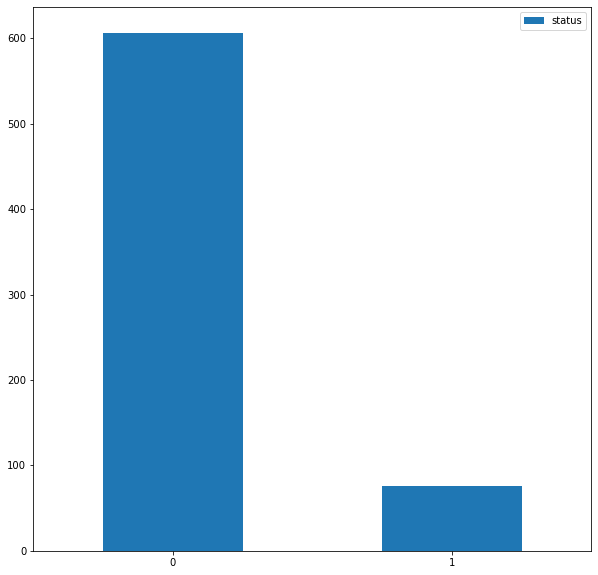

In [404]:
df['status'].value_counts().plot(kind='bar', rot=0,  legend=True, figsize=(10,10))

In [ ]:
fig, ax = plt.subplots()
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
ax = df['status'].value_counts().plot(kind='bar', rot=0, color=my_colors, legend=True, figsize=(10,10))
colors = {'no default: 606':'blue','default: 76':'red'}
labels = ['no default: 606','default: 76']
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)